Regresssion problem

Import libraries, define device to run the models

In [9]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split

print(device)


cuda


In [10]:
raw_dataset = pd.read_csv("auto-mpg.data", names=["mpg","cylinders","displacement",
                                                  "horsepower","weight","acceleration","model year",
                                                  "origin","car name"],
                     na_values = "?", comment='\t',
                     sep=" ", skipinitialspace=True)
raw_dataset.pop("car name")
raw_dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Clean the dataset:

In [11]:
raw_dataset.isna().sum()
raw_dataset = raw_dataset.dropna()
origin = raw_dataset.pop('origin')
raw_dataset['USA'] = (origin == 1)*1.0
raw_dataset['Europe'] = (origin == 2)*1.0
raw_dataset['Japan'] = (origin == 3)*1.0

#Normalized data
data_mean = raw_dataset.mean()
data_std = raw_dataset.std()
raw_dataset  = (raw_dataset - data_mean)/data_std

raw_dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
393,0.455359,-0.862911,-0.519972,-0.479835,-0.220842,0.021267,1.634321,0.773608,-0.457538,-0.501749
394,2.633448,-0.862911,-0.930889,-1.363154,-0.997859,3.283479,1.634321,-1.289347,2.180035,-0.501749
395,1.095974,-0.862911,-0.567753,-0.531795,-0.803605,-1.428605,1.634321,0.773608,-0.457538,-0.501749
396,0.583482,-0.862911,-0.711097,-0.661694,-0.415097,1.108671,1.634321,0.773608,-0.457538,-0.501749
397,0.967851,-0.862911,-0.720653,-0.583754,-0.303253,1.398646,1.634321,0.773608,-0.457538,-0.501749


Create the train, validation and test set

In [12]:

label_data = np.asarray(raw_dataset.pop("mpg"))
feature_data = np.asarray(raw_dataset.iloc[:])



trainX, testX, trainY, testY = train_test_split(feature_data, label_data, train_size=0.8, shuffle=True)
testX, valX, testY, valY = train_test_split(testX, testY, train_size=0.5, shuffle=True)

print(len(valY),len(testY),len(trainY))

print("traint set",trainX.shape)


class CustomDataSet(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class CustomDataSet(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_ds = CustomDataSet(trainX, trainY)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=0)

val_ds = CustomDataSet(valX, valY)
val_loader = DataLoader(val_ds, batch_size=10, num_workers=0)

test_ds = CustomDataSet(testX, testY)
test_loader = DataLoader(test_ds, batch_size=10, num_workers=0)





40 39 313
traint set (313, 9)


1. Network #1: basic regression with 1 layer and 1 neuron

----------
epoch 1/20
1/15, train_loss: 1.5174
2/15, train_loss: 2.7172
3/15, train_loss: 1.7093
4/15, train_loss: 1.6460
5/15, train_loss: 1.2093
6/15, train_loss: 2.4712
7/15, train_loss: 1.0004
8/15, train_loss: 1.7743
9/15, train_loss: 1.8606
10/15, train_loss: 1.7903
11/15, train_loss: 2.4298
12/15, train_loss: 1.4794
13/15, train_loss: 1.4551
14/15, train_loss: 2.4809
15/15, train_loss: 2.3246
16/15, train_loss: 1.0881
epoch 1 average loss: 1.8096
----------
epoch 2/20
1/15, train_loss: 1.6917
2/15, train_loss: 2.4098
3/15, train_loss: 1.7493
4/15, train_loss: 2.0193
5/15, train_loss: 2.0666
6/15, train_loss: 1.2008
7/15, train_loss: 2.8122
8/15, train_loss: 1.6515
9/15, train_loss: 1.6075
10/15, train_loss: 2.5998
11/15, train_loss: 1.3833
12/15, train_loss: 1.7614
13/15, train_loss: 1.9714
14/15, train_loss: 0.7279
15/15, train_loss: 1.1381
16/15, train_loss: 2.1667
epoch 2 average loss: 1.8098
saved new best metric model
current epoch: 2  current mse: 1.4264 best mse: 1.4264 a

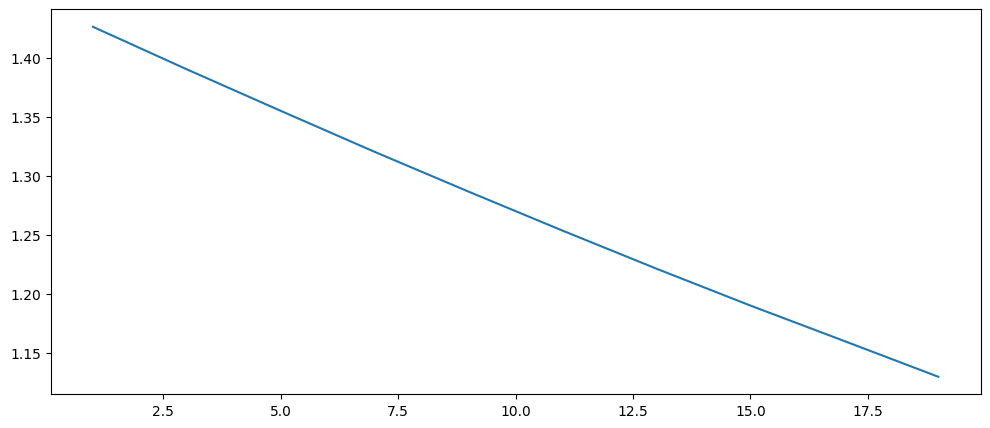

In [13]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(in_features=9,out_features=1)

    def forward(self, x):
        return self.linear(x)

model = LinearRegression().to(device)
loss_function_val = torch.nn.MSELoss(reduction='mean')

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

history = []

best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
epoch_num=20
val_interval = 2

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device).float().reshape(-1,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device).float(), val_data[1].to(device).float().reshape(-1,1)
                y_pred = torch.cat([y_pred, model(val_inputs)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            sumMSE = loss_function(y_pred,y)
            history.append((epoch,sumMSE.cpu()))
            if sumMSE < best_metric:
                best_metric = sumMSE
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} "
                  f" current mse: {sumMSE:.4f} best mse: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data[0].to(device).float(), test_data[1].to(device).float().reshape(-1,1)
        y_pred = torch.cat([y_pred, model(test_inputs)], dim=0)
        y = torch.cat([y, test_labels], dim=0)
    sumMSE = loss_function(y_pred,y)
print(f"test completed, mse: {sumMSE:.4f} ")
x_data = [x for x, _ in history]
y_data = [y for _, y in history]
plt.figure(figsize=(12, 5))
plt.plot(x_data,y_data)
plt.show()


2. Network #2: 4-layer network
a. Layer 1 – 10 neurons
b. Layer 2 – 20 neurons
c. Layer 3 – 10 neurons
d. Layer 4 – output neuron

----------
epoch 1/20
1/15, train_loss: 1.4720
2/15, train_loss: 1.1984
3/15, train_loss: 1.2679
4/15, train_loss: 0.7579
5/15, train_loss: 0.9471
6/15, train_loss: 1.0851
7/15, train_loss: 1.3258
8/15, train_loss: 0.9494
9/15, train_loss: 1.2488
10/15, train_loss: 1.7016
11/15, train_loss: 1.1768
12/15, train_loss: 0.9762
13/15, train_loss: 0.7335
14/15, train_loss: 1.1737
15/15, train_loss: 1.3691
16/15, train_loss: 1.1395
epoch 1 average loss: 1.1577
----------
epoch 2/20
1/15, train_loss: 1.3080
2/15, train_loss: 1.0718
3/15, train_loss: 1.3338
4/15, train_loss: 0.9873
5/15, train_loss: 0.9455
6/15, train_loss: 1.3185
7/15, train_loss: 1.0374
8/15, train_loss: 1.4282
9/15, train_loss: 1.2711
10/15, train_loss: 0.6286
11/15, train_loss: 1.1133
12/15, train_loss: 1.8297
13/15, train_loss: 1.0894
14/15, train_loss: 1.2772
15/15, train_loss: 0.9103
16/15, train_loss: 0.6770
epoch 2 average loss: 1.1392
saved new best metric model
current epoch: 2  current mse: 0.9015 best mse: 0.9015 a

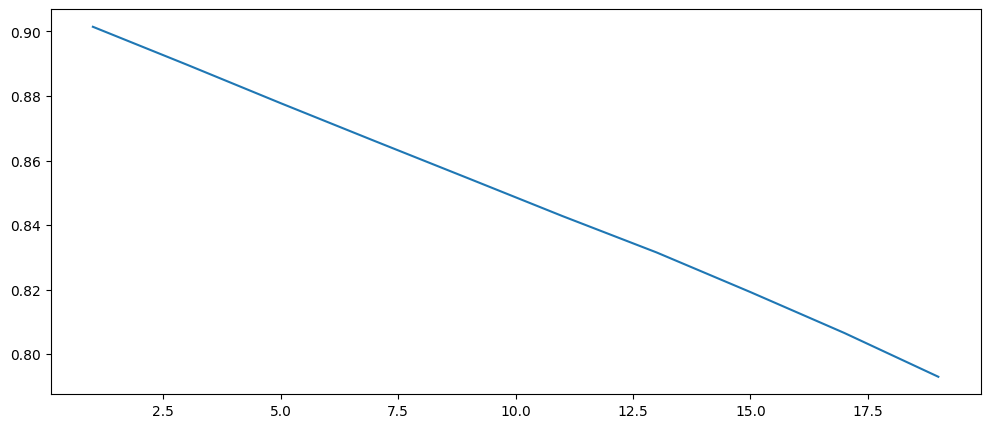

In [14]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.layer1 = nn.Linear(in_features=9,out_features=10)
        self.layer2 = nn.Linear(10, 20)
        self.layer3 = nn.Linear(20, 10)
        self.layer4 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.layer4(self.relu(self.layer3(out)))
        return out

model = LinearRegression().to(device)
loss_function_val = torch.nn.MSELoss(reduction='mean')

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

history = []

best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
epoch_num=20
val_interval = 2

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device).float().reshape(-1,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device).float(), val_data[1].to(device).float().reshape(-1,1)
                y_pred = torch.cat([y_pred, model(val_inputs)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            sumMSE = loss_function(y_pred,y)
            history.append((epoch,sumMSE.cpu()))
            if sumMSE < best_metric:
                best_metric = sumMSE
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} "
                  f" current mse: {sumMSE:.4f} best mse: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data[0].to(device).float(), test_data[1].to(device).float().reshape(-1,1)
        y_pred = torch.cat([y_pred, model(test_inputs)], dim=0)
        y = torch.cat([y, test_labels], dim=0)
    sumMSE = loss_function(y_pred,y)
print(f"test completed, mse: {sumMSE:.4f} ")
x_data = [x for x, _ in history]
y_data = [y for _, y in history]
plt.figure(figsize=(12, 5))
plt.plot(x_data,y_data)
plt.show()

3. Network #3: 5- layer network
a. Layer 1 – 10 neurons
b. Layer 2 – 20 neurons
c. Layer 3 – 30 neurons
d. Layer 4 – 20 neurons
e. Layer 5 – output neuron

----------
epoch 1/20
1/15, train_loss: 0.8493
2/15, train_loss: 0.9327
3/15, train_loss: 1.0929
4/15, train_loss: 0.9042
5/15, train_loss: 0.7491
6/15, train_loss: 0.7817
7/15, train_loss: 1.1194
8/15, train_loss: 1.2659
9/15, train_loss: 1.3061
10/15, train_loss: 1.0949
11/15, train_loss: 0.9444
12/15, train_loss: 1.5940
13/15, train_loss: 1.0347
14/15, train_loss: 1.2689
15/15, train_loss: 1.2690
16/15, train_loss: 1.4282
epoch 1 average loss: 1.1022
----------
epoch 2/20
1/15, train_loss: 0.7425
2/15, train_loss: 1.1756
3/15, train_loss: 1.2038
4/15, train_loss: 0.9123
5/15, train_loss: 1.7859
6/15, train_loss: 0.9074
7/15, train_loss: 1.2503
8/15, train_loss: 1.3826
9/15, train_loss: 0.8605
10/15, train_loss: 1.1328
11/15, train_loss: 0.8011
12/15, train_loss: 1.0487
13/15, train_loss: 1.3983
14/15, train_loss: 0.5672
15/15, train_loss: 1.0490
16/15, train_loss: 1.2378
epoch 2 average loss: 1.0910
saved new best metric model
current epoch: 2  current mse: 0.8848 best mse: 0.8848 a

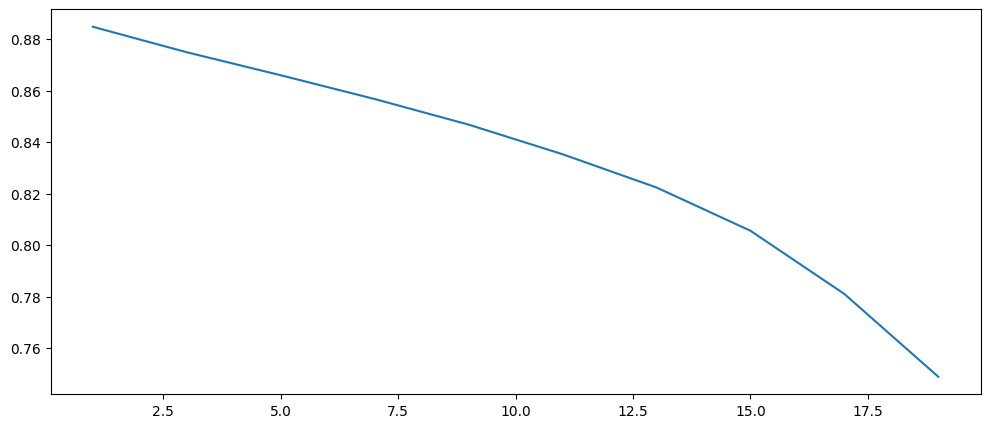

In [15]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.layer1 = nn.Linear(in_features=9,out_features=10)
        self.layer2 = nn.Linear(10, 20)
        self.layer3 = nn.Linear(20, 30)
        self.layer4 = nn.Linear(30, 20)
        self.layer5 = nn.Linear(20, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        out = self.layer5(self.relu(self.layer4(out)))
        return out

model = LinearRegression().to(device)
loss_function_val = torch.nn.MSELoss(reduction='mean')

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

history = []

best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
epoch_num=20
val_interval = 2

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device).float().reshape(-1,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device).float(), val_data[1].to(device).float().reshape(-1,1)
                y_pred = torch.cat([y_pred, model(val_inputs)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            sumMSE = loss_function(y_pred,y)
            history.append((epoch,sumMSE.cpu()))
            if sumMSE < best_metric:
                best_metric = sumMSE
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} "
                  f" current mse: {sumMSE:.4f} best mse: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data[0].to(device).float(), test_data[1].to(device).float().reshape(-1,1)
        y_pred = torch.cat([y_pred, model(test_inputs)], dim=0)
        y = torch.cat([y, test_labels], dim=0)
    sumMSE = loss_function(y_pred,y)
print(f"test completed, mse: {sumMSE:.4f} ")
x_data = [x for x, _ in history]
y_data = [y for _, y in history]
plt.figure(figsize=(12, 5))
plt.plot(x_data,y_data)
plt.show()

Which of the three models had the least amount of error for validation? In my tests, the third model had a better performance with the test dataset, but the results were very similar with the second one after running several test.